# Gradient Checking for DoMINO Sensitivity Analysis

In this notebook, we will:

1. Run a baseline DoMINO inference to compute aerodynamic force and sensitivity fields.
2. Perturb the geometry along the sensitivity direction with various $\epsilon$ magnitudes to approximate drag gradients via finite differences.
3. Compare the adjoint-based gradient to the finite-difference estimates using a log-symmetrical plot.

To start, we execute steps from the [main notebook](./main.ipynb) to compute the baseline sensitivity results.


In [1]:
import torch
from pathlib import Path
import hydra
from omegaconf import DictConfig
import numpy as np
import pyvista as pv

from main import DoMINOInference
from physicsnemo.distributed import DistributedManager

torch.cuda.set_per_process_memory_fraction(0.99)

In [2]:
with hydra.initialize(version_base="1.3", config_path="./conf"):
    cfg: DictConfig = hydra.compose(config_name="config")

In [3]:
DistributedManager.initialize()
dist = DistributedManager()

if dist.world_size > 1:
    torch.distributed.barrier()  # ty: ignore[possibly-unbound-attribute]

/home/psharpe/GitHub/physicsnemo/physicsnemo/distributed/manager.py:415: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this is a single process job
  warn(


In [4]:
domino = DoMINOInference(
    cfg=cfg,
    model_checkpoint_path="./DoMINO.0.41.pt",
    dist=dist,
)

Note here, that, for speed, we're using a decimated (i.e., downsampled) version of the geometry.

In [5]:
input_file = Path(".") / "geometries" / "drivaer_1_single_solid_decimated3.stl"
mesh: pv.PolyData = pv.read(input_file)  # ty: ignore[invalid-assignment]

First, we'll run a baseline DoMINO inference to compute the sensitivity information:

In [6]:
results: dict[str, np.ndarray] = domino(
    mesh=mesh,
    stream_velocity=38.889,  # m/s
    stencil_size=7,
    air_density=1.205,  # kg/m^3
)

And, we'll postprocess those results as we did in the main notebook:

In [7]:
for key, value in results.items():
    if len(value) == mesh.n_cells:
        mesh.cell_data[key] = value
    elif len(value) == mesh.n_points:
        mesh.point_data[key] = value

sensitivity_results: dict[str, np.ndarray] = domino.postprocess_point_sensitivities(
    results=results, mesh=mesh
)

for key, value in sensitivity_results.items():
    mesh[key] = value

Laplacian smoothing: 100%|██████████| 20/20 [00:01<00:00, 17.58it/s]


Now, we'll start adding new functionality, starting with a function that computes the drag given deviations of various magnitudes in the sensitivity direction:

In [8]:
print(f"Initial drag force: {results['aerodynamic_force'][0]} N")

def get_drag(
        epsilon: float,
        sensitivities: np.ndarray,
    ) -> float:
        """
        Compute the drag force for a mesh perturbed along a sensitivity direction.

        This function perturbs the mesh geometry by a small amount `epsilon` in the direction
        of the provided `sensitivities` (typically a sensitivity field such as the gradient
        of drag with respect to point positions), then evaluates the drag force for the
        perturbed geometry using the DoMINO inference pipeline. Uses a finite-difference
        approximation to estimate the drag gradient.

        Args:
            epsilon: The perturbation magnitude to apply to the mesh points.
            sensitivities: An array of shape (n_points, 3) representing the direction and
                magnitude of perturbation for each mesh point.

        Returns:
            The drag force (float) computed for the perturbed mesh.
        """
        warped_mesh = pv.PolyData(
            mesh.points + epsilon * sensitivities,
            mesh.faces,
        )
        warped_results: dict[str, np.ndarray] = domino(
            mesh=warped_mesh,
            stream_velocity=38.889,  # m/s
            stencil_size=7,
            air_density=1.205,  # kg/m^3
        )
        drag = warped_results["aerodynamic_force"][0]
        return float(drag)

Initial drag force: 713.9151000976562 N


Now, we assemble a list of $\epsilon$ values to use for the finite-difference approximation:

In [9]:
import numpy as np

epsilons = np.array([0] + [
    sign * number * 10**exponent
    for exponent in range(-12, 0)
    for number in np.logspace(0, 1, 5)
    for sign in [1, -1]
])
epsilons

array([ 0.00000000e+00,  1.00000000e-12, -1.00000000e-12,  1.77827941e-12,
       -1.77827941e-12,  3.16227766e-12, -3.16227766e-12,  5.62341325e-12,
       -5.62341325e-12,  1.00000000e-11, -1.00000000e-11,  1.00000000e-11,
       -1.00000000e-11,  1.77827941e-11, -1.77827941e-11,  3.16227766e-11,
       -3.16227766e-11,  5.62341325e-11, -5.62341325e-11,  1.00000000e-10,
       -1.00000000e-10,  1.00000000e-10, -1.00000000e-10,  1.77827941e-10,
       -1.77827941e-10,  3.16227766e-10, -3.16227766e-10,  5.62341325e-10,
       -5.62341325e-10,  1.00000000e-09, -1.00000000e-09,  1.00000000e-09,
       -1.00000000e-09,  1.77827941e-09, -1.77827941e-09,  3.16227766e-09,
       -3.16227766e-09,  5.62341325e-09, -5.62341325e-09,  1.00000000e-08,
       -1.00000000e-08,  1.00000000e-08, -1.00000000e-08,  1.77827941e-08,
       -1.77827941e-08,  3.16227766e-08, -3.16227766e-08,  5.62341325e-08,
       -5.62341325e-08,  1.00000000e-07, -1.00000000e-07,  1.00000000e-07,
       -1.00000000e-07,  

Now for the expensive part: the gradient checking. Here, we compute the drag force for a mesh perturbed along a sensitivity direction by varying $\epsilon$ in a log-symmetrical manner:

In [10]:
from tqdm import tqdm

mesh = mesh.cell_data_to_point_data(pass_cell_data=True)

### [Gradient Checking: Raw Sensitivities]
# Compute drag for each epsilon using the raw sensitivity field.
# Returns: np.ndarray of shape (len(epsilons),)
drag_raw: np.ndarray = np.array(
    [get_drag(epsilon, mesh.point_data["raw_sensitivity_cells"]) for epsilon in tqdm(epsilons, desc="Raw Sensitivities")]
)
print(f"{drag_raw=!r}")

### [Gradient Checking: Smoothed Sensitivities]
# Compute drag for each epsilon using the smoothed sensitivity field.
# Returns: np.ndarray of shape (len(epsilons),)
drag_smooth: np.ndarray = np.array(
    [get_drag(epsilon, mesh.point_data["smooth_sensitivity_point"]) for epsilon in tqdm(epsilons, desc="Smoothed Sensitivities")]
)
print(f"{drag_smooth=!r}")

Raw Sensitivities:   0%|          | 0/121 [00:00<?, ?it/s]

Raw Sensitivities: 100%|██████████| 121/121 [43:35<00:00, 21.62s/it]


drag_raw=array([ 713.9151001 ,  713.9151001 ,  713.91516113,  713.9151001 ,
        713.91516113,  713.9151001 ,  713.91516113,  713.9151001 ,
        713.91516113,  713.9151001 ,  713.91516113,  713.9151001 ,
        713.91516113,  713.9151001 ,  713.91516113,  713.9151001 ,
        713.91516113,  713.9151001 ,  713.91516113,  713.9151001 ,
        713.91516113,  713.9151001 ,  713.91516113,  713.9151001 ,
        713.91516113,  713.9151001 ,  713.91516113,  713.9151001 ,
        713.91516113,  713.91503906,  713.91503906,  713.91503906,
        713.91503906,  713.9151001 ,  713.9151001 ,  713.91503906,
        713.91503906,  713.91448975,  713.91314697,  713.91088867,
        713.91113281,  713.91088867,  713.91113281,  713.9140625 ,
        713.91009521,  713.91363525,  713.9107666 ,  713.91351318,
        713.90771484,  713.91491699,  713.9083252 ,  713.91491699,
        713.9083252 ,  713.8649292 ,  713.90673828,  713.88446045,
        713.90081787,  713.88519287,  713.90704346,  

Smoothed Sensitivities: 100%|██████████| 121/121 [44:26<00:00, 22.03s/it]

drag_smooth=array([ 713.9151001 ,  713.9151001 ,  713.9151001 ,  713.9151001 ,
        713.9151001 ,  713.9151001 ,  713.9151001 ,  713.9151001 ,
        713.9151001 ,  713.9151001 ,  713.9151001 ,  713.9151001 ,
        713.9151001 ,  713.9151001 ,  713.9151001 ,  713.9151001 ,
        713.9151001 ,  713.9151001 ,  713.9151001 ,  713.9151001 ,
        713.9151001 ,  713.9151001 ,  713.9151001 ,  713.9151001 ,
        713.9151001 ,  713.9151001 ,  713.9151001 ,  713.9151001 ,
        713.9151001 ,  713.9151001 ,  713.9151001 ,  713.9151001 ,
        713.9151001 ,  713.91503906,  713.9151001 ,  713.91497803,
        713.91503906,  713.91503906,  713.91534424,  713.91625977,
        713.91357422,  713.91625977,  713.91357422,  713.91461182,
        713.91412354,  713.91644287,  713.91430664,  713.91693115,
        713.91455078,  713.91345215,  713.91351318,  713.91345215,
        713.91351318,  713.87322998,  713.91461182,  713.8762207 ,
        713.91107178,  713.87774658,  713.89849854

## Results

Now, we can plot the results:

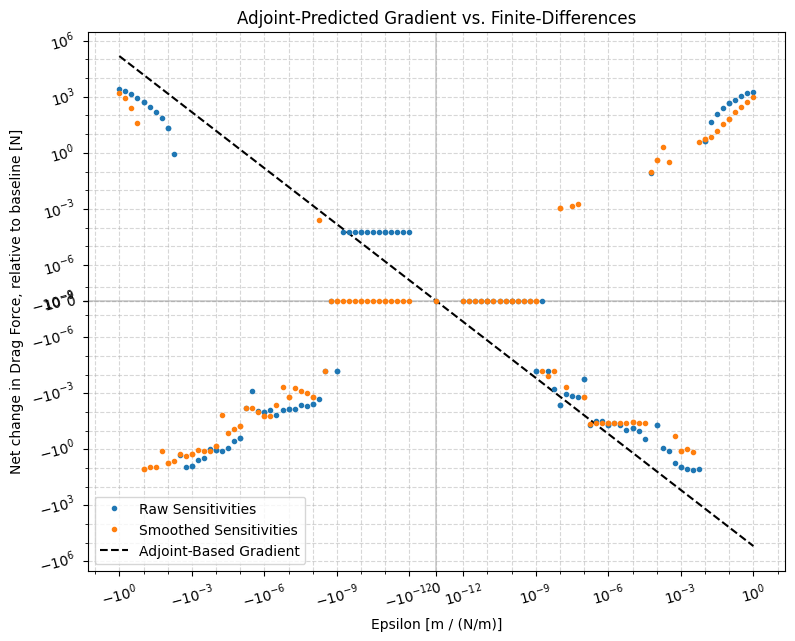

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(9, 7))

data = {
    "Raw Sensitivities": drag_raw,
    "Smoothed Sensitivities": drag_smooth,
}

for name, drag in data.items():

    baseline_drag = drag[epsilons == 0][0]
    drag_delta = drag - baseline_drag

    plt.plot(
        epsilons,
        drag_delta,
        ".",
        label=name,
        color="C0" if name == "Raw Sensitivities" else "C1",
    )

x = np.unique(np.concatenate([line.get_xdata() for line in plt.gca().get_lines()]))
x_minscale = np.min(np.abs(x[x != 0]))
x_maxscale = np.max(np.abs(x[x != 0]))

x_minscale = 1e-12
# x_maxscale=1e0

sorted_x = np.sort(
    np.concatenate(
        (
            np.logspace(np.log10(x_minscale) - 3, np.log10(x_maxscale), 100),
            np.abs(epsilons),
        )
    )
)
sorted_x = np.concatenate((-sorted_x[::-1], sorted_x))

analytical_gradient = -1 * mesh.n_cells

plt.plot(
    sorted_x,
    analytical_gradient * sorted_x,
    "--k",
    label="Adjoint-Based Gradient",
    zorder=1.9,
)

plt.xscale("symlog", linthresh=x_minscale)
plt.yscale("symlog", linthresh=np.abs(analytical_gradient) * x_minscale)

xax = plt.gca().xaxis
yax = plt.gca().yaxis

for ax in ["x", "y"]:
    for kind in ["major", "minor"]:
        a = plt.gca().xaxis if ax == "x" else plt.gca().yaxis
        locator = ticker.SymmetricalLogLocator(
            base=1000 if kind == "major" else 10,
            linthresh=(
                x_minscale if ax == "x" else np.abs(analytical_gradient) * x_minscale
            ),
        )
        locator.numticks = 1000

        if kind == "major":
            a.set_major_locator(locator)
        else:
            a.set_minor_locator(locator)

plt.xticks(rotation=15, va="top")
plt.yticks(rotation=15, va="center")
plt.axhline(0, color="k", linewidth=1.2, zorder=1, alpha=0.2)
plt.axvline(0, color="k", linewidth=1.2, zorder=1, alpha=0.2)


# Add grid for better readability
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.xlabel("Epsilon [m / (N/m)]")
plt.ylabel("Net change in Drag Force, relative to baseline [N]")
plt.title("Adjoint-Predicted Gradient vs. Finite-Differences")
plt.legend(loc="lower left")
plt.show()
